# HR-аналитика: прогнозирование оттока сотрудников.

Компания ***«Работа с заботой»*** помогает бизнесу оптимизировать управление персоналом: избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам потребовалось машинное обучение, с помощью которого получается быстрее и точнее отвечать на вопросы бизнеса. Одной из важнейших задач является предсказание оттока работников, так как внезапные увольнения несут в себе серьёзные риски.  

Компания предоставила данные с характеристиками сотрудников компании и сформулировали следующие задачи:  
- построить модель, которая сможет **предсказать уровень удовлетворённости сотрудника работой** на основе данных заказчика,  
- построить модель, которая сможет **предсказать: уволится ли сотрудник из компании**.  

В нашем распоряжении есть следующие данные:  
Для решения первой задачи:  
- `id` — идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — было ли повышение за последний год;
- `last_year_violations` — нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника руководителем;
- `salary` — ежемесячная зарплата сотрудника;  
Целевой признак:
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, непрерывная величина от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.  

Для решения второй задачи входные признаки те же, а целевой отличается:  
- `quit` -  увольнение сотрудника из компании, бинарный признак.

# 1. Предсказание уровня удовлетворённости сотрудника работой

## Загрузка данных

In [ ]:
!pip install phik -q
!pip install scikit-learn==1.5.2 -q
!pip install matplotlib==3.5.1 -q

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import phik

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

RANDOM_STATE=42

In [ ]:
try:
    train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', sep=',')
    X_test = pd.read_csv('/datasets/test_features.csv', sep=',')
    y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', sep=',')
except:
    train = pd.read_csv('train_job_satisfaction_rate.csv', sep=',')
    X_test = pd.read_csv('test_features.csv', sep=',')
    y_test = pd.read_csv('test_target_job_satisfaction_rate.csv', sep=',')

In [ ]:
display(train.head())
display(X_test.head())
display(y_test.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Определим функцию для вывода основной информации о датасете

In [ ]:
def data_info(df):
    display(df.head(20))
    print()
    display(df.describe())
    print()
    df.info()

In [ ]:
data_info(train)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [ ]:
data_info(X_test)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [ ]:
data_info(y_test)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Названия переменных и типы данных указаны корректно, тренировочная выборка состоит из 4 000 наблюдений, тестовая из 2 000, при этом есть пропущенные значения как в обучающей, так и в тестовой выборке. Рассмотрим данные детальнее.

## Предобработка данных

In [ ]:
train = train.set_index('id')
X_test = X_test.set_index('id')
y_test = y_test.set_index('id')

### Обработка неявных дубликатов

Выведем уникальные значения категориальных признаков

In [ ]:
for name, df in [['train', train], ['X_test', X_test]]:
    print(f'Датасет {name}:')
    for i in df.select_dtypes(object).columns:
        print(f'Уникальные значения признака "{i}":')
        print(df[i].unique())
        print()

Датасет train:
Уникальные значения признака "dept":
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

Уникальные значения признака "level":
['junior' 'middle' 'sinior' nan]

Уникальные значения признака "workload":
['medium' 'high' 'low']

Уникальные значения признака "last_year_promo":
['no' 'yes']

Уникальные значения признака "last_year_violations":
['no' 'yes']

Датасет X_test:
Уникальные значения признака "dept":
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

Уникальные значения признака "level":
['junior' 'middle' 'sinior' nan]

Уникальные значения признака "workload":
['medium' 'low' 'high' ' ']

Уникальные значения признака "last_year_promo":
['no' 'yes']

Уникальные значения признака "last_year_violations":
['no' 'yes']



Есть неявные дубликаты в тестовой выборке: по-разному записаны пропущенные значения (np.nan и '  '), заменить их в тестовой выборке мы не можем, поэтому примем к сведению, что в данных есть такая проблема и учтём при создании пайплайна для подготовки данных. Можно исправить ошибку в написании уровня занимаемой должности - заменим 'sinior' на 'senior'.

In [ ]:
train['level'] = train['level'].replace('sinior', 'senior')

Проверим:

In [ ]:
for name, df in [['train', train], ['X_test', X_test]]:
    print(f'Датасет {name}:')
    for i in df.select_dtypes(object).columns:
        print(f'Уникальные значения признака "{i}":')
        print(df[i].unique())
        print()

Датасет train:
Уникальные значения признака "dept":
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

Уникальные значения признака "level":
['junior' 'middle' 'senior' nan]

Уникальные значения признака "workload":
['medium' 'high' 'low']

Уникальные значения признака "last_year_promo":
['no' 'yes']

Уникальные значения признака "last_year_violations":
['no' 'yes']

Датасет X_test:
Уникальные значения признака "dept":
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

Уникальные значения признака "level":
['junior' 'middle' 'sinior' nan]

Уникальные значения признака "workload":
['medium' 'low' 'high' ' ']

Уникальные значения признака "last_year_promo":
['no' 'yes']

Уникальные значения признака "last_year_violations":
['no' 'yes']



### Удаление явных дубликатов

Проверим наличие явных дубликатов

In [ ]:
print('Количество явных дубликатов:')
print(f'train - {train.duplicated().sum()}')
print(f'X_test - {X_test.duplicated().sum()}')
print(f'y_test - {y_test.duplicated().sum()}')

Количество явных дубликатов:
train - 245
X_test - 557
y_test - 1902


In [ ]:
print('Количество явных дубликатов с учётом индексов:')
print(f'train - {train.reset_index().duplicated().sum()}')
print(f'X_test - {X_test.reset_index().duplicated().sum()}')
print(f'y_test - {y_test.reset_index().duplicated().sum()}')

Количество явных дубликатов с учётом индексов:
train - 0
X_test - 0
y_test - 0


В тренировочной выборке обнаружено 245 строк, отличающихся только id. С одной стороны, эти данные нельзя однозначно считать дубликатами: поскольку идентификаторы разные, вероятно, это информация о разных сотрудниках. С другой стороны, если оставить повторяющиеся строки, при обучении модель может подстроиться под повторяющиеся данные и переобучиться. Также, дубликаты не несут новой информации о зависимостях в данных, поэтому целесообразно удалить их из обучающей выборки. В тестовой оставим без изменений, поскольку на обучение они не влияют.

In [ ]:
train = train.drop_duplicates()

### Пропущенные значения

In [ ]:
print('Количество пропущенных значений:')
print(f'train:\n{train.isna().sum().sort_values(ascending=False)}\n')
print(f'X_test:\n{X_test.isna().sum().sort_values(ascending=False)}\n')
print(f'y_test:\n{y_test.isna().sum().sort_values(ascending=False)}\n')

Количество пропущенных значений:
train:
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

X_test:
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

y_test:
job_satisfaction_rate    0
dtype: int64



Обнаружено 10 пропущенных значений в тренировочной выборке и 5 в тестовой, пока не будем обрабатывать их, заполним в пайплайне.

### Промежуточный вывод

В ходе предобработки данных были удалены повторяющиеся строки в тренировочной выборке, так как они могут исказить результаты моделирования: переобучить модель, излишне подстроить её под повторяющиеся данные. Также, были устранены неявные дубликаты: разные способы обозначения пропусков приведены к одному виду. Обнаружены пропущенные значения, но их заполнение выполним в пайплайне.

## Исследовательский анализ данных

### Определение функций

Зададим функции для визуализации распределений количественных и категориальных признаков

In [ ]:
# Визуализация количественных признаков и вывод описательной статистики
def num_features_stats(feature, feature_name, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    plt.suptitle(title, fontsize=16)

    # Гистограмма
    sns.histplot(x=feature, kde=True, ax=ax[0])
    ax[0].set_title('Распределение данных')
    ax[0].set_xlabel(feature_name)
    ax[0].set_ylabel('Частота')
    ax[0].grid(True)

    # Диаграмма размаха
    sns.boxplot(x=feature, ax=ax[1])
    ax[1].set_title('Диаграмма размаха')
    ax[1].set_xlabel(feature_name)
    ax[1].grid(True)

    plt.show()

    print()
    print('Описательная статистика')
    print(feature.describe())

# Визуализация категориальных признаков
def cat_features_stats(feature, feature_name, title):

    sns.set(style='whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    plt.suptitle(title, fontsize=16)

    sns.countplot(y=feature, ax=ax[0], order = feature.value_counts().index)
    ax[0].set_title('Столбчатая диаграмма')
    ax[0].set_ylabel(feature_name)
    ax[0].set_xlabel('Количество наблюдений')
    ax[0].tick_params(axis='y', rotation=45)
    ax[0].grid(False)


    # Построение круговой диаграммы без подписей
    wedges, texts, autotexts = ax[1].pie(
        feature.value_counts(ascending=False),
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'linewidth': 3, 'edgecolor': 'white'}
    )
    ax[1].set_title('Круговая диаграмма')
    ax[1].set_ylabel(None)

    # Добавление легенды
    ax[1].legend(wedges,
                 feature.value_counts(ascending=False).index,
                 title=feature_name,
                 loc="center left",
                 bbox_to_anchor=(1, 0, 0.5, 1))

    plt.show()

### Визуализация и анализ

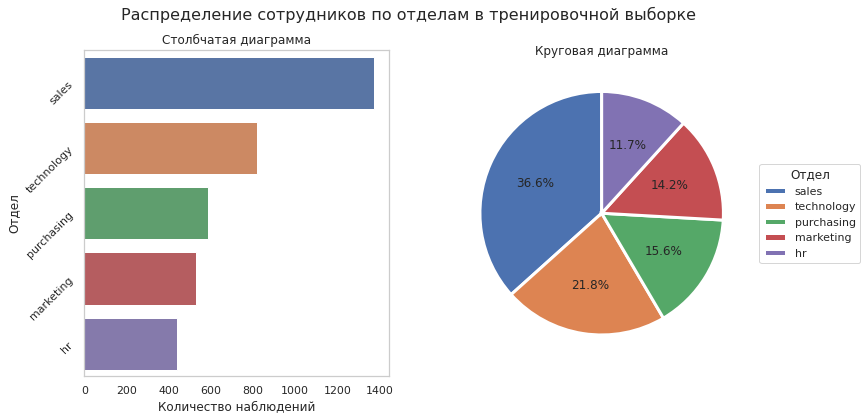

In [ ]:
cat_features_stats(train['dept'], 'Отдел', 'Распределение сотрудников по отделам в тренировочной выборке')

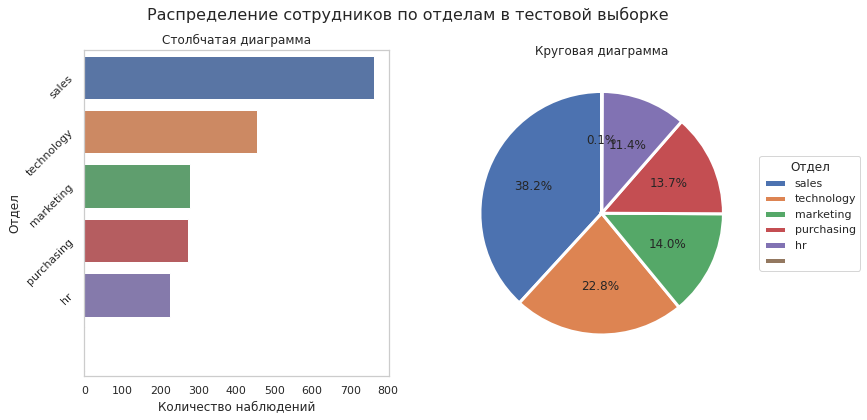

In [ ]:
cat_features_stats(X_test['dept'], 'Отдел', 'Распределение сотрудников по отделам в тестовой выборке')

Как в обучающей, так и в тестовой выборке преобладают сотрудники отдела продаж (36,6% - 38,2%) и технологического отдела (21,8% - 22,8%), в наименьшей степени  представлен HR-отдел (11,7% - 11,4%).

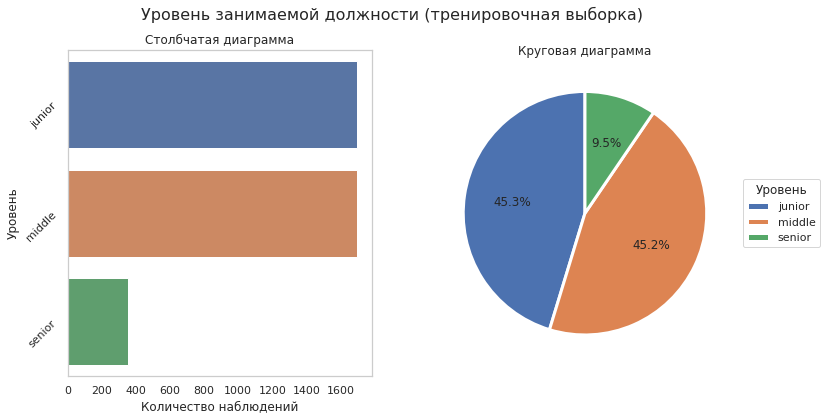

In [ ]:
cat_features_stats(train['level'], 'Уровень', 'Уровень занимаемой должности (тренировочная выборка)')

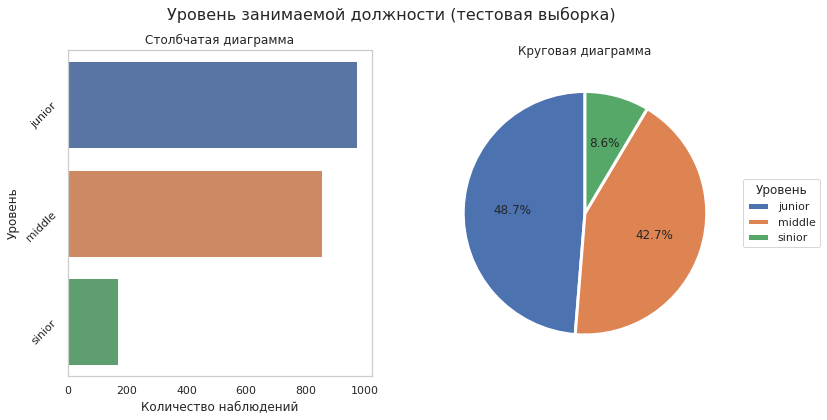

In [ ]:
cat_features_stats(X_test['level'], 'Уровень', 'Уровень занимаемой должности (тестовая выборка)')

Распределение сотрудников по уровню занимаемой должности также схоже между выборками: 90-92% должностей уровней `junior` или `middle`, при этом в обучающем наборе данных их доли между собой практически равны, а в тестовом - специалистов уровня `junior` на 6 процентных пунктов больше, чем `middle`.

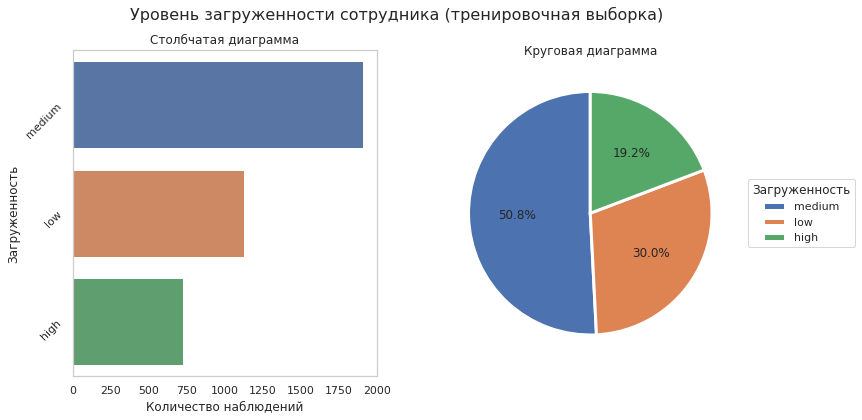

In [ ]:
cat_features_stats(train['workload'], 'Загруженность', 'Уровень загруженности сотрудника (тренировочная выборка)')

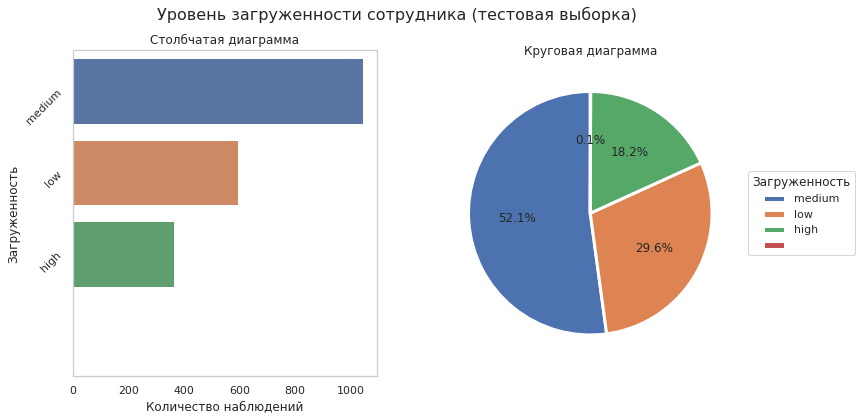

In [ ]:
cat_features_stats(X_test['workload'], 'Загруженность', 'Уровень загруженности сотрудника (тестовая выборка)')

Загруженность половины сотрудников компании оценивается как средняя, при этом около 30% слабо загружены и около 20% (18,2% - 19,2%) имеют высокую степень нагрузки.

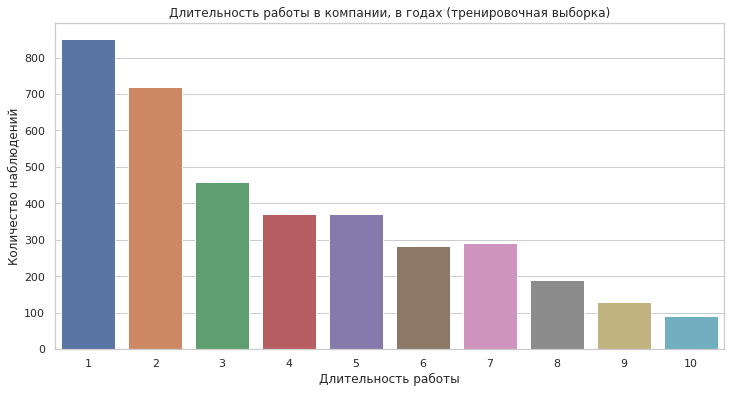

In [ ]:
#num_features_stats(train['employment_years'], 'Длительность работы', 'Длительность работы в компании, в годах (тренировочная выборка)')
plt.figure(figsize=(12,6))
sns.countplot(x=train['employment_years'])
plt.title('Длительность работы в компании, в годах (тренировочная выборка)')
plt.ylabel('Количество наблюдений')
plt.xlabel('Длительность работы')
plt.show();

In [ ]:
train['employment_years'].describe()

count    3755.000000
mean        3.817044
std         2.557142
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

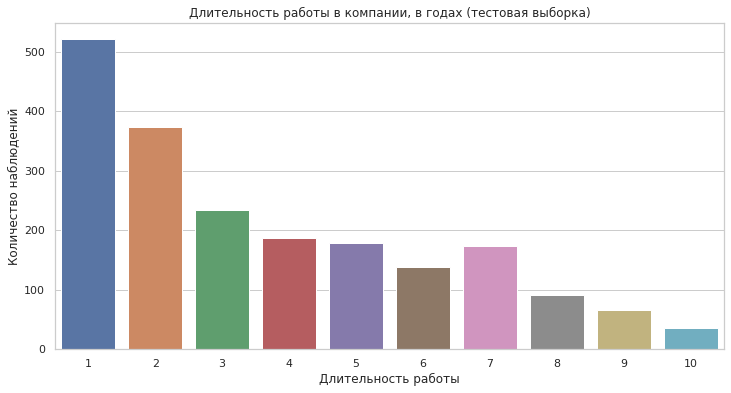

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x=X_test['employment_years'])
plt.title('Длительность работы в компании, в годах (тестовая выборка)')
plt.ylabel('Количество наблюдений')
plt.xlabel('Длительность работы')
plt.show();

In [ ]:
X_test['employment_years'].describe()

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

Как в тренировочной, так и в тестовой выборке, 50% сотрудников работают в компании не более 3 лет и лишь 25% трудятся больше 6 лет.

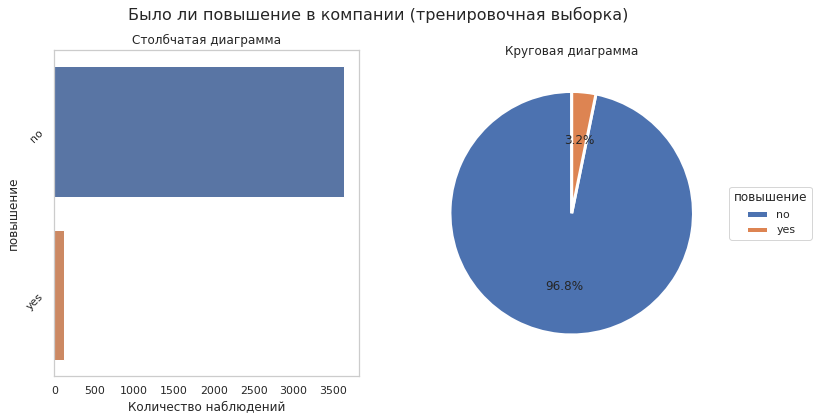

In [ ]:
cat_features_stats(train['last_year_promo'], 'повышение', 'Было ли повышение в компании (тренировочная выборка)')

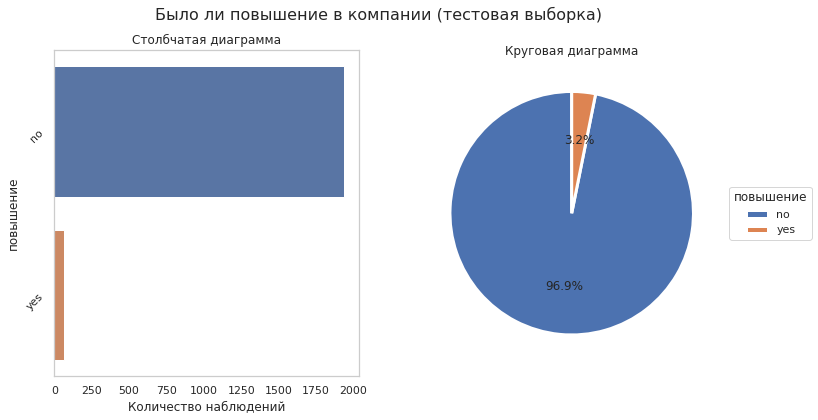

In [ ]:
cat_features_stats(X_test['last_year_promo'], 'повышение', 'Было ли повышение в компании (тестовая выборка)')

97% сотрудников компании не получали повышение за последний год.

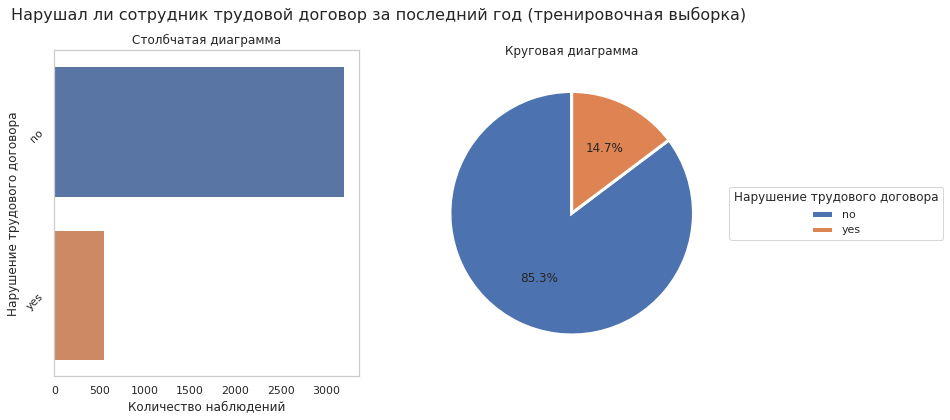

In [ ]:
cat_features_stats(train['last_year_violations'], 'Нарушение трудового договора', 'Нарушал ли сотрудник трудовой договор за последний год (тренировочная выборка)')

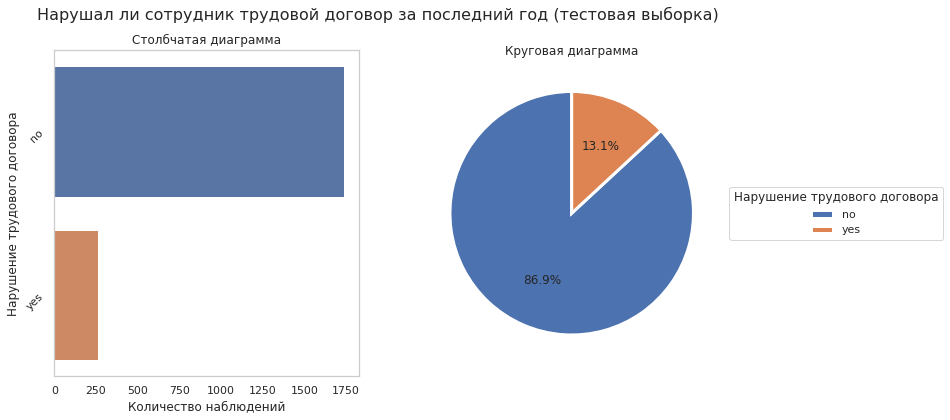

In [ ]:
cat_features_stats(X_test['last_year_violations'], 'Нарушение трудового договора', 'Нарушал ли сотрудник трудовой договор за последний год (тестовая выборка)')

Большая часть сотрудников (85,3% в обучающем и 87% в тестовом датасете) не нарушали трудовой договор за последний год, однако есть 13-15%, которые всё-же допустили нарушения.

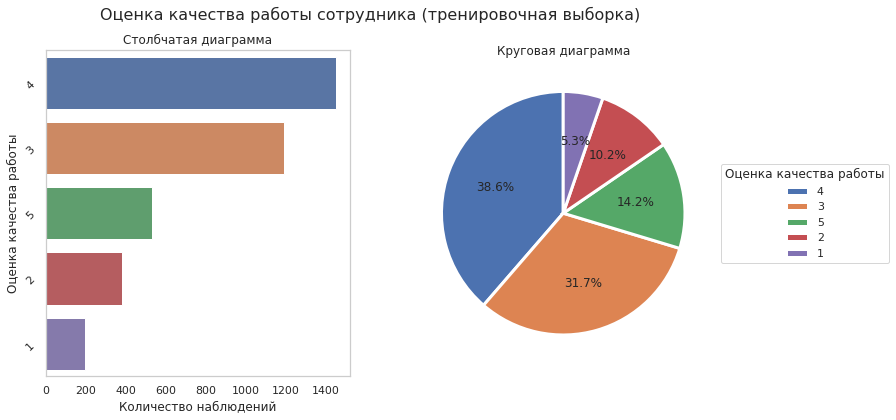

In [ ]:
cat_features_stats(train['supervisor_evaluation'], 'Оценка качества работы', 'Оценка качества работы сотрудника (тренировочная выборка)')

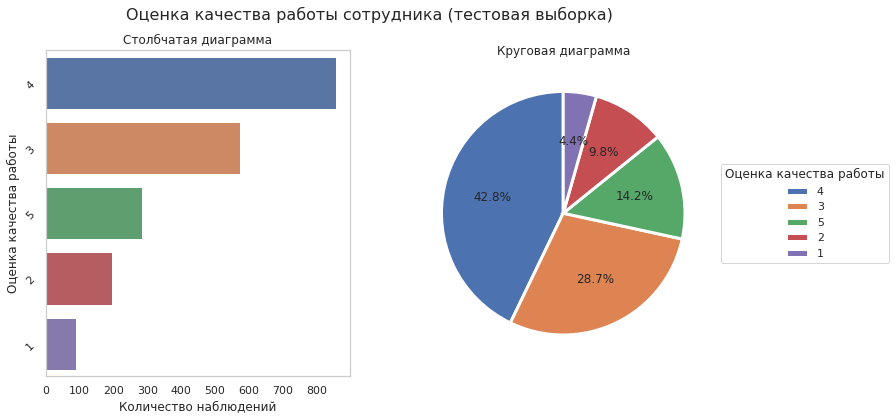

In [ ]:
cat_features_stats(X_test['supervisor_evaluation'], 'Оценка качества работы', 'Оценка качества работы сотрудника (тестовая выборка)')

Работу около 40% сотрудников руководители оценили на `4`, около 30% на `3`, и лишь 14.2% на `5`. По большей части руководство удовлетворено качеством работы сотрудников, однако доля тех, чьей работой руководитель не удовлетворён (оценки `1` и `2`) составляет 14,2% - 15,5%, чуть больше чем оценок `5`.

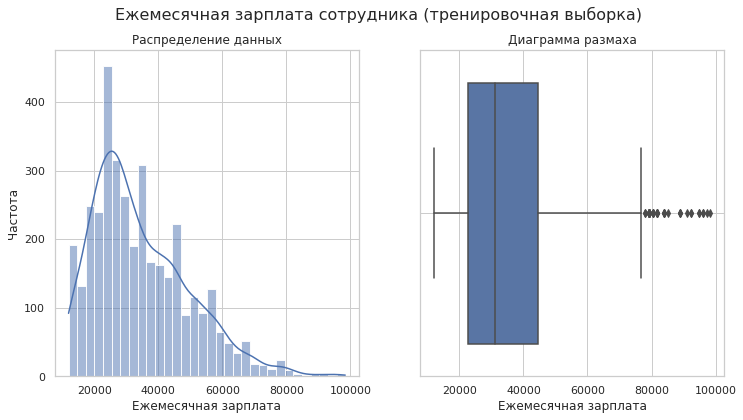


Описательная статистика
count     3755.000000
mean     34457.416778
std      15050.643870
min      12000.000000
25%      22800.000000
50%      31200.000000
75%      44400.000000
max      98400.000000
Name: salary, dtype: float64


In [ ]:
num_features_stats(train['salary'], 'Ежемесячная зарплата', 'Ежемесячная зарплата сотрудника (тренировочная выборка)')

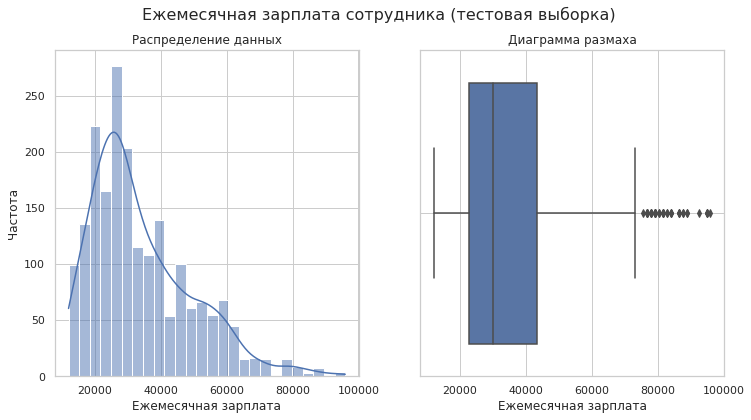


Описательная статистика
count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


In [ ]:
num_features_stats(X_test['salary'], 'Ежемесячная зарплата', 'Ежемесячная зарплата сотрудника (тестовая выборка)')

Средняя зарплата сотрудников составляет 34 000 - 34 500 р., при этом для 75% сотрудников заработная плата не превышает 44 400 р. в обучающей выборке и 43 200 р. в тренировочной.

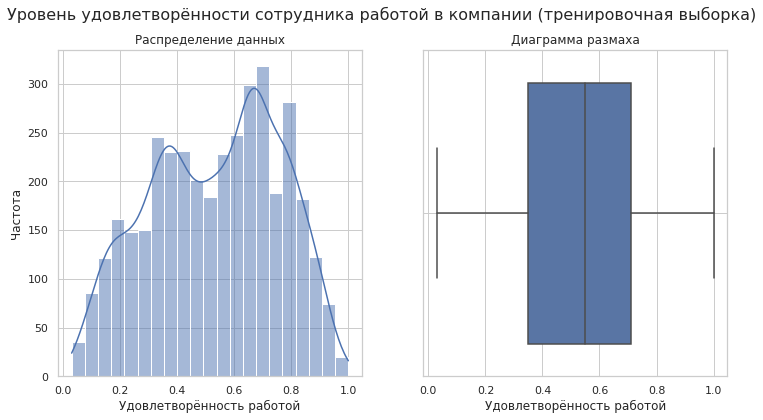


Описательная статистика
count    3755.000000
mean        0.532554
std         0.226393
min         0.030000
25%         0.350000
50%         0.550000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


In [ ]:
num_features_stats(train['job_satisfaction_rate'], 'Удовлетворённость работой', 'Уровень удовлетворённости сотрудника работой в компании (тренировочная выборка)')

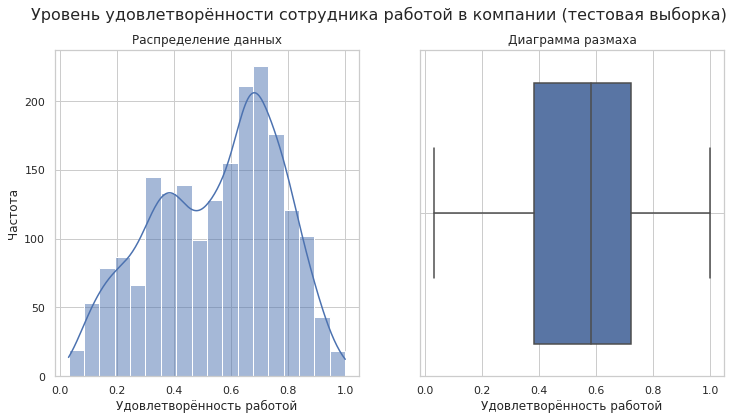


Описательная статистика
count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64


In [ ]:
num_features_stats(y_test['job_satisfaction_rate'], 'Удовлетворённость работой', 'Уровень удовлетворённости сотрудника работой в компании (тестовая выборка)')

В среднем степень удовлетворённости сотрудников работой составляет 53-55%, половина работников оценивает место работы не более чем на 55%, при этом лишь 25% оценили свою удовлетворённость выше, чем на 71%.

### Корреляционный анализ

In [ ]:
train.phik_matrix(interval_cols = [
    'salary',
    'job_satisfaction_rate']).style.background_gradient(cmap ='coolwarm')

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.018079,0.025931,0.000000,0.000000,0.100579,0.270239,0.074739
level,0.000000,1.000000,0.404459,0.675467,0.100352,0.000000,0.000000,0.714411,0.077260
workload,0.018079,0.404459,1.000000,0.165879,0.057938,0.000000,0.037565,0.785277,0.043958
employment_years,0.025931,0.675467,0.165879,1.000000,0.180832,0.043766,0.000000,0.469992,0.319331
last_year_promo,0.000000,0.100352,0.057938,0.180832,1.000000,0.011274,0.016247,0.211173,0.191464
last_year_violations,0.000000,0.000000,0.000000,0.043766,0.011274,1.000000,0.183221,0.000000,0.566993
supervisor_evaluation,0.100579,0.000000,0.037565,0.000000,0.016247,0.183221,1.000000,0.000000,0.762964
salary,0.270239,0.714411,0.785277,0.469992,0.211173,0.000000,0.000000,1.000000,0.149599
job_satisfaction_rate,0.074739,0.077260,0.043958,0.319331,0.191464,0.566993,0.762964,0.149599,1.000000


Наиболее тесная линейная связь у целевого признака с фактом наличия/отсутствия `нарушений трудового договора` (заметная связь: 0,567) и с `оценкой работы сотрудника руководителем` (высокая степень связи: 0,763). Высокая теснота связи между `зарплатой` и `нагрузкой` (0,785), а также `зарплатой` и `уровнем занимаемой должности` (0,714). При этом мультиколлинеарности не обнаружено.

### Промежуточный вывод

В большей степени представлены данные о сотрудниках `отдела продаж` и `технологического отдела`, подавляющее большинство (90% - 92%) должностей уровня `junior` и `middle` (между собой распределены примерно в равном соотношении), 50% работников обладают
`средней степенью загруженности`, при этом около 30% `слабо загруженны` и 20% обладают `высокой нагрузкой`. Корреляционный анализ показал, что `нагрузка` и `уровень должности` оказывают наибольшее линейное воздействие на `зарплату`. `Средняя зарплата` составлет `34 - 34,5 тыс. р.`, при этом 75% получает `не более 71 тыс.р`. `Удовлетворённость работой` коррелирует с `оценкой работы сотрудника руководителем` и фактом наличия/отсутствия `нарушений трудового договора`. В среднем сотрудники оценивают работу на `0,55` и лишь для 25% этот показатель превышает `0,71`.

## Подготовка данных

Выполним подготовку данных в пайплайне, для этого выделим входные признаки и таргет там.  
Чтобы данные по `X` и `y` шли в одном порядке, сначала объединим их по индексам, а потом разделим повторно:

In [ ]:
test = X_test.merge(y_test, left_index=True, right_index=True)

X_train = train.drop(columns='job_satisfaction_rate')
y_train = train['job_satisfaction_rate']

X_test = test.drop(columns='job_satisfaction_rate')
y_test = test['job_satisfaction_rate']

Выделем столбцы для кодирования и масштабирования:  
- признаки `salary` и `employment_years` являются количественными, `supervisor_evaluation` хоть и относится скорее к категориальным, его значения уже упорядочены,  
- признаки `level` и `workload` упорядоченые, поэтому для них применим `OrdinalEncoder()`,  
- для признаков `dept`, `last_year_promo`, `last_year_violations` `применим OneHotEncoder()`

In [ ]:
num_col = ['salary', 'employment_years', 'supervisor_evaluation']
ord_col = ['level', 'workload']
ohe_col =['dept', 'last_year_promo', 'last_year_violations']

### Создание пайплайна для подготовки данных

In [ ]:
ohe_pipe = Pipeline(
    [
        (
            'simple_imputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
         ),

        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [ ]:
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),

        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan)
        ),

        (
            'simple_imputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [ ]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_col),
        ('ord', ord_pipe, ord_col),
        ('num', MinMaxScaler(), num_col)
    ]
)

### Промежуточный вывод

В данном шаге были учтены особенности признаков и разработан пайплайн для подготовки данных к обучению модели.

## Обучение моделей

### Финальный пайплайн

Задаём финальный пайплайн

In [ ]:
final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

### Выбор моделей, гиперпараметров и методов масштабирования для рассмотрения

Определим список моделей и гиперпараметров для подбора:

In [ ]:
param_distributions = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_features': range(2, 9),
        'models__min_samples_leaf': range(1, 16),
        'models__min_samples_split': range(2, 21),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [Lasso()],
        'models__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [Ridge()],
        'models__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']
    }
]

Определим функцию симметричного среднего абсолютного процентного отклонения SMAPE для оценки качества моделей:

In [ ]:
def smape(y_test, y_pred):
    error = abs(y_test - y_pred)
    mean_abs = (abs(y_test) + abs(y_pred)) / 2
    return 100/len(y_test) * np.sum(error/mean_abs)

smape_score = make_scorer(smape, greater_is_better=False)

Запустим перебор гиперпараметров и обучим получившуюся модель

### Подбор моделей, гиперпараметров и методов масштабирования

In [ ]:
randomized_search = RandomizedSearchCV(
    final,
    param_distributions,
    scoring=smape_score,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [ ]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('simple_imputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simple_impute...
                                         'models__alpha': [0.01, 0.1, 1.0, 10.0,
                                                           100.0],
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [Ridge()],
                                         'models__alpha': [0.01, 0.1, 1.0, 10.0,
                                                           100.0],
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [ ]:
print('Метрика SMAPE (Симметричное среднее абсолютное процентное отклонение):', -randomized_search.best_score_)

Метрика SMAPE (Симметричное среднее абсолютное процентное отклонение): 15.675637985214887


In [ ]:
print('Метрика SMAPE на тестовой выборке:', smape(y_test, randomized_search.predict(X_test)))

Метрика SMAPE на тестовой выборке: 14.070182974061632


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Промежуточный вывод

С помощью RandomizedSearchCV() был осуществлён перебор моделей, гиперапараметров и методов масштабирования. Оптимальной оказалась модель дерева решений с гиперпараметрами max_features=8, min_samples_leaf=6, min_samples_split=13, random_state=42, масштабирование осуществлялось скелером RobustScaler(). Качество модели оценивалось метрикой SMAPE (симметричное среднее абсолютное процентное отклонение, оптимальное значение <= 15 на тестовой), на обучающей выборке её значение составило 15,68, а на тестовой 14,07, что свидетельсвует о высокой точности модели.

# 2. Прогнозирование оттока сотрудников

## Загрузка данных

In [ ]:
try:
    train_clf = pd.read_csv('/datasets/train_quit.csv', sep=',')
    X_test_clf = pd.read_csv('/datasets/test_features.csv', sep=',')
    y_test_clf = pd.read_csv('/datasets/test_target_quit.csv', sep=',')
except:
    train_clf = pd.read_csv('train_quit.csv', sep=',')
    X_test_clf = pd.read_csv('test_features.csv', sep=',')
    y_test_clf = pd.read_csv('test_target_quit.csv', sep=',')

In [ ]:
data_info(train_clf)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [ ]:
data_info(X_test_clf)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [ ]:
data_info(y_test_clf)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


### Промежуточный вывод

В наборе данных представленны те же входные признаки, отличается целевой - теперь это категориальный признак `quit`. Объемы тренировочной и тестовой выборок те же (4 000 и 2 000 соответственно), типы данных и названи столбцов корректны, есть пропущенные значения.

## Предобработка данных

In [ ]:
train_clf = train_clf.set_index('id')
X_test_clf = X_test_clf.set_index('id')
y_test_clf = y_test_clf.set_index('id')

### Неявные дубликаты

Выведем уникальные значения всех признаков:

In [ ]:
for name, df in [['train_clf', train_clf], ['X_test_clf', X_test_clf]]:
    print(f'Датасет {name}:')
    for i in df.select_dtypes(object).columns:
        print(f'Уникальные значения признака "{i}":')
        print(df[i].unique())
        print()

Датасет train_clf:
Уникальные значения признака "dept":
['sales' 'purchasing' 'marketing' 'technology' 'hr']

Уникальные значения признака "level":
['middle' 'junior' 'sinior']

Уникальные значения признака "workload":
['high' 'medium' 'low']

Уникальные значения признака "last_year_promo":
['no' 'yes']

Уникальные значения признака "last_year_violations":
['no' 'yes']

Уникальные значения признака "quit":
['no' 'yes']

Датасет X_test_clf:
Уникальные значения признака "dept":
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

Уникальные значения признака "level":
['junior' 'middle' 'sinior' nan]

Уникальные значения признака "workload":
['medium' 'low' 'high' ' ']

Уникальные значения признака "last_year_promo":
['no' 'yes']

Уникальные значения признака "last_year_violations":
['no' 'yes']



Аналогичные проблемы с пропусками и написанием позиции `senior`, заменим '' на np.nan и `sinior` на `senior`.

In [ ]:
train_clf['level'] = train_clf['level'].replace('sinior', 'senior')

In [ ]:
for name, df in [['train_clf', train_clf], ['X_test_clf', X_test_clf]]:
    print(f'Датасет {name}:')
    for i in df.select_dtypes(object).columns:
        print(f'Уникальные значения признака "{i}":')
        print(df[i].unique())
        print()

Датасет train_clf:
Уникальные значения признака "dept":
['sales' 'purchasing' 'marketing' 'technology' 'hr']

Уникальные значения признака "level":
['middle' 'junior' 'senior']

Уникальные значения признака "workload":
['high' 'medium' 'low']

Уникальные значения признака "last_year_promo":
['no' 'yes']

Уникальные значения признака "last_year_violations":
['no' 'yes']

Уникальные значения признака "quit":
['no' 'yes']

Датасет X_test_clf:
Уникальные значения признака "dept":
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

Уникальные значения признака "level":
['junior' 'middle' 'sinior' nan]

Уникальные значения признака "workload":
['medium' 'low' 'high' ' ']

Уникальные значения признака "last_year_promo":
['no' 'yes']

Уникальные значения признака "last_year_violations":
['no' 'yes']



### Явные дубликаты

In [ ]:
print('Количество явных дубликатов:')
print(f'train_clf - {train_clf.duplicated().sum()}')
print(f'X_test_clf - {X_test_clf.duplicated().sum()}')
print(f'y_test_clf - {y_test_clf.duplicated().sum()}')

Количество явных дубликатов:
train_clf - 1413
X_test_clf - 557
y_test_clf - 1998


Доля дубликатов в обучающей выборке слишком высока, удаление повторяющхся строк может привести к дисбалансу классов, поэтому пока оставим без изменений и будем принимать решения исходя из оценки качества модели.

### Пропущенные значения

In [ ]:
print('Количество пропущенных значений:')
print(f'train_clf:\n{train_clf.isna().sum().sort_values(ascending=False)}\n')
print(f'X_test_clf:\n{X_test_clf.isna().sum().sort_values(ascending=False)}\n')
print(f'y_test_clf:\n{y_test_clf.isna().sum().sort_values(ascending=False)}\n')

Количество пропущенных значений:
train_clf:
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

X_test_clf:
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

y_test_clf:
quit    0
dtype: int64



### Промежуточный вывод

В данных обнаружены те же проблемы, что и в первой задаче, однако в данном случае дубликатов в обучающей выборке гораздо больше, было принято решение не удалять их, чтобы не столкнуться с проблемой дисбаланса классов и не терять много информации. Пропущенные значения также будут обработаны в пайплайне.

## Исследовательский анализ данных

### Визуализация и анализ признаков

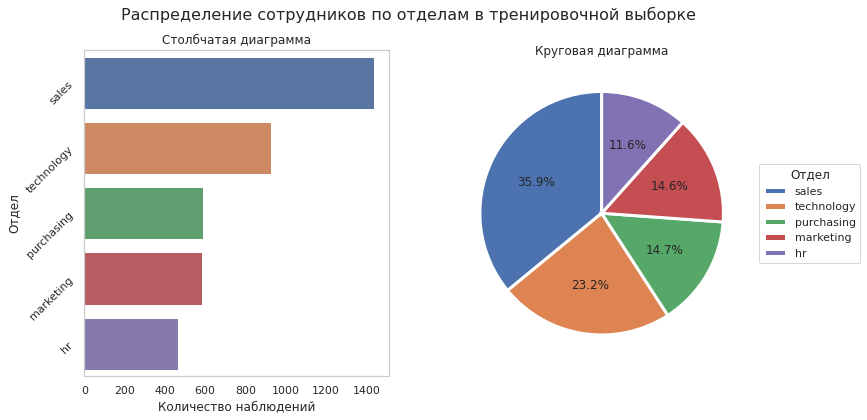

In [ ]:
cat_features_stats(train_clf['dept'], 'Отдел', 'Распределение сотрудников по отделам в тренировочной выборке')

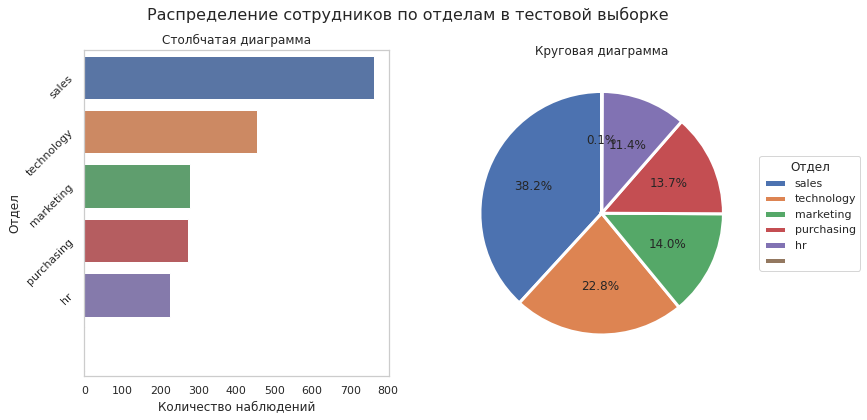

In [ ]:
cat_features_stats(X_test_clf['dept'], 'Отдел', 'Распределение сотрудников по отделам в тестовой выборке')

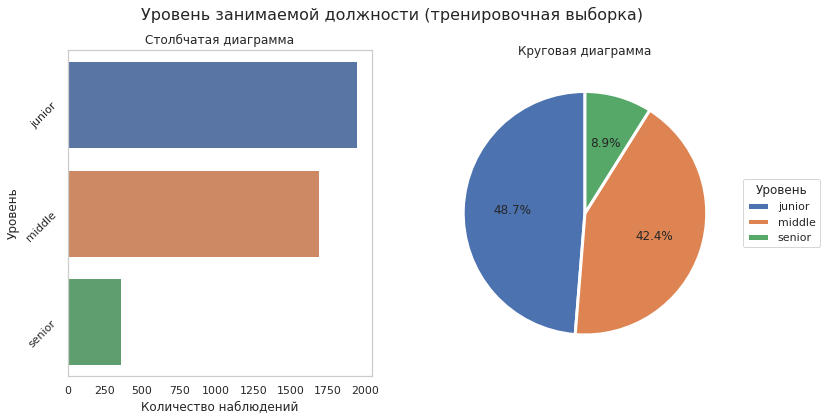

In [ ]:
cat_features_stats(train_clf['level'], 'Уровень', 'Уровень занимаемой должности (тренировочная выборка)')

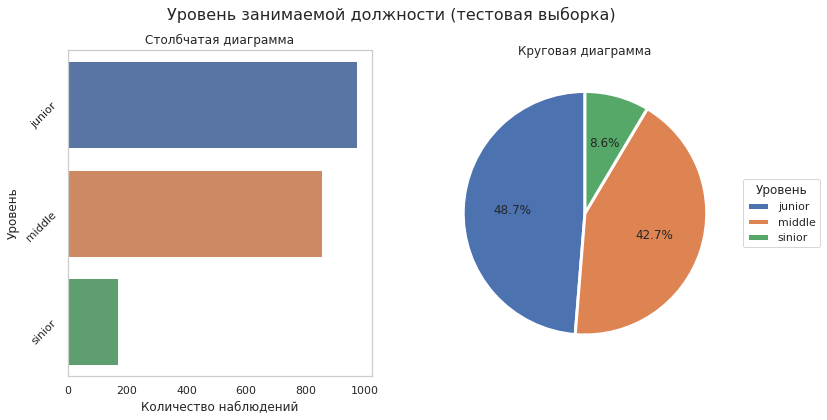

In [ ]:
cat_features_stats(X_test_clf['level'], 'Уровень', 'Уровень занимаемой должности (тестовая выборка)')

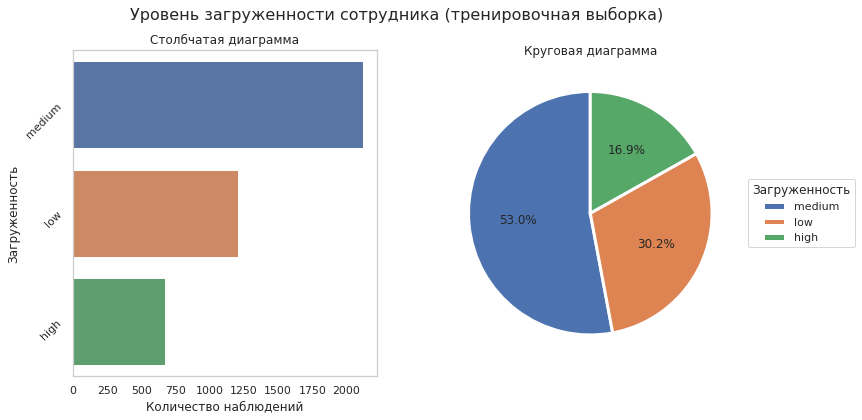

In [ ]:
cat_features_stats(train_clf['workload'], 'Загруженность', 'Уровень загруженности сотрудника (тренировочная выборка)')

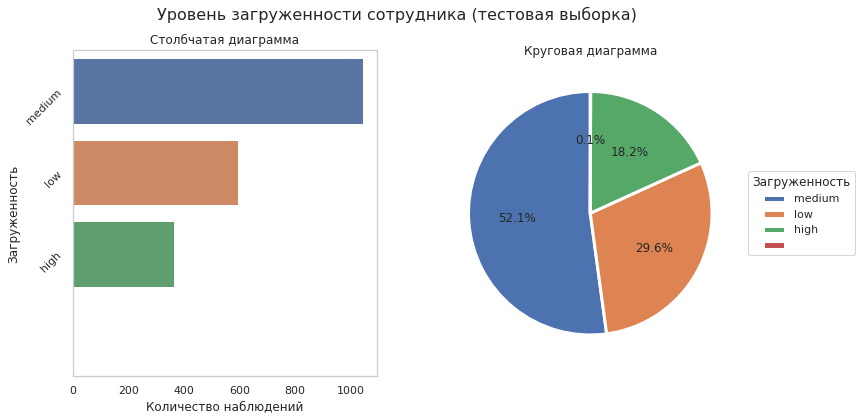

In [ ]:
cat_features_stats(X_test_clf['workload'], 'Загруженность', 'Уровень загруженности сотрудника (тестовая выборка)')

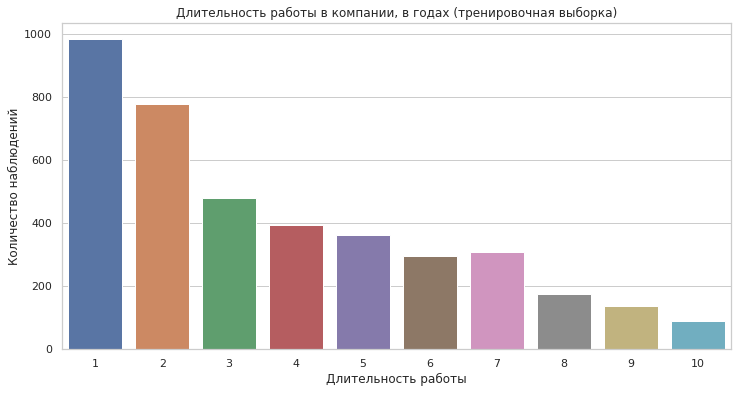

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x=train_clf['employment_years'])
plt.title('Длительность работы в компании, в годах (тренировочная выборка)')
plt.ylabel('Количество наблюдений')
plt.xlabel('Длительность работы')
plt.show();

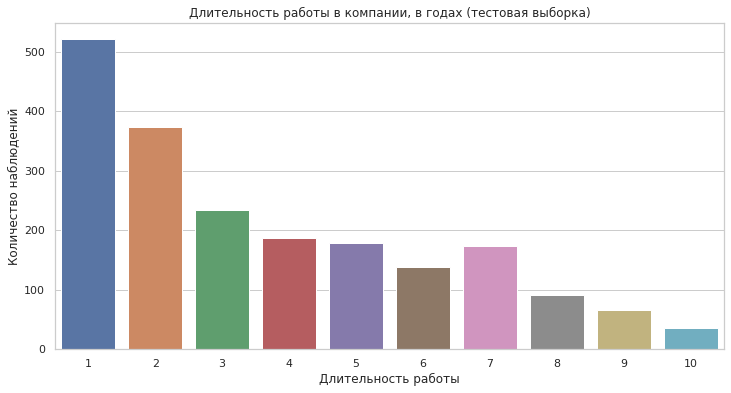

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x=X_test_clf['employment_years'])
plt.title('Длительность работы в компании, в годах (тестовая выборка)')
plt.ylabel('Количество наблюдений')
plt.xlabel('Длительность работы')
plt.show();

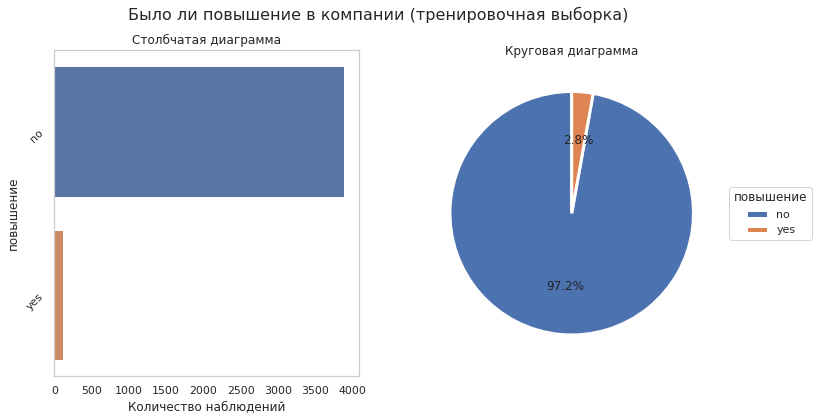

In [ ]:
cat_features_stats(train_clf['last_year_promo'], 'повышение', 'Было ли повышение в компании (тренировочная выборка)')

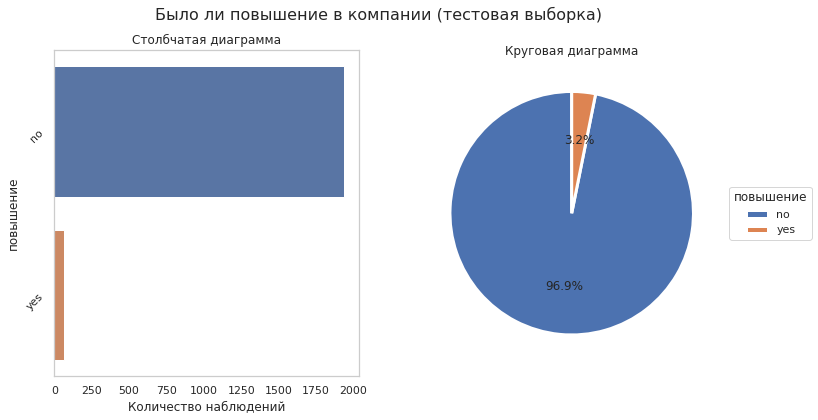

In [ ]:
cat_features_stats(X_test_clf['last_year_promo'], 'повышение', 'Было ли повышение в компании (тестовая выборка)')

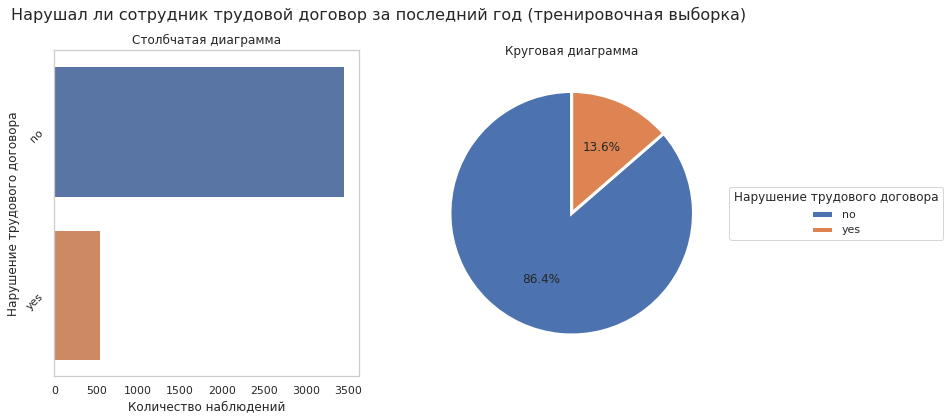

In [ ]:
cat_features_stats(train_clf['last_year_violations'], 'Нарушение трудового договора', 'Нарушал ли сотрудник трудовой договор за последний год (тренировочная выборка)')

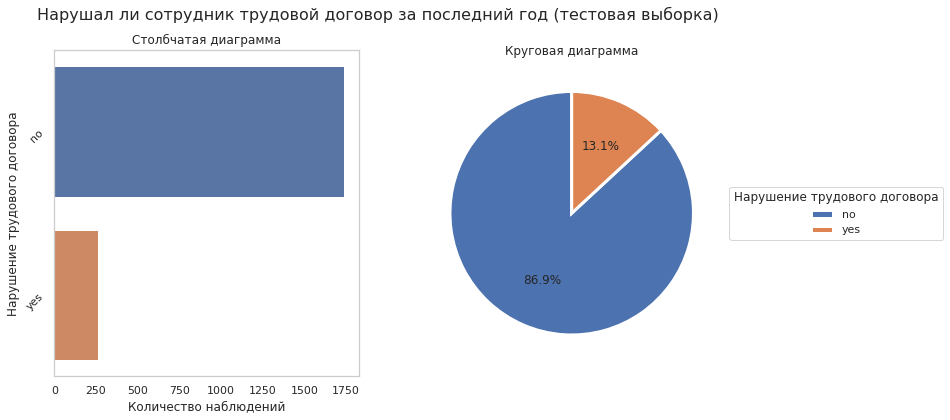

In [ ]:
cat_features_stats(X_test_clf['last_year_violations'], 'Нарушение трудового договора', 'Нарушал ли сотрудник трудовой договор за последний год (тестовая выборка)')

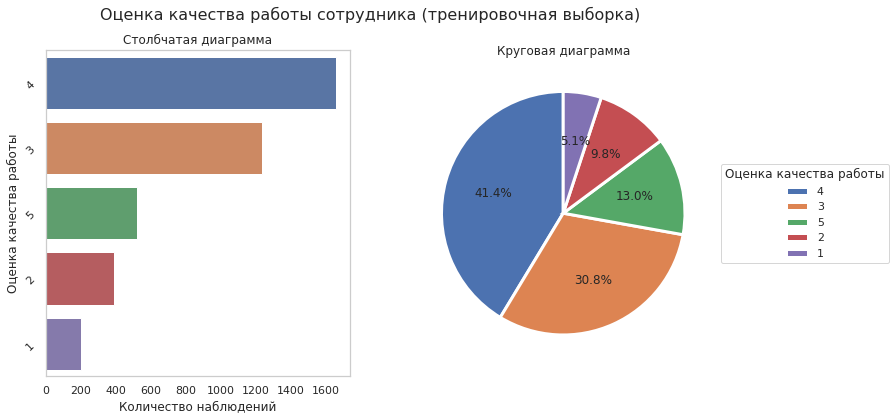

In [ ]:
cat_features_stats(train_clf['supervisor_evaluation'], 'Оценка качества работы', 'Оценка качества работы сотрудника (тренировочная выборка)')

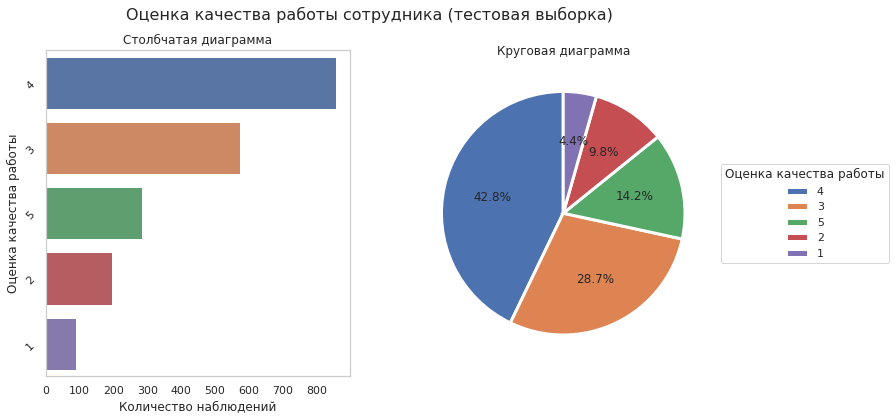

In [ ]:
cat_features_stats(X_test_clf['supervisor_evaluation'], 'Оценка качества работы', 'Оценка качества работы сотрудника (тестовая выборка)')

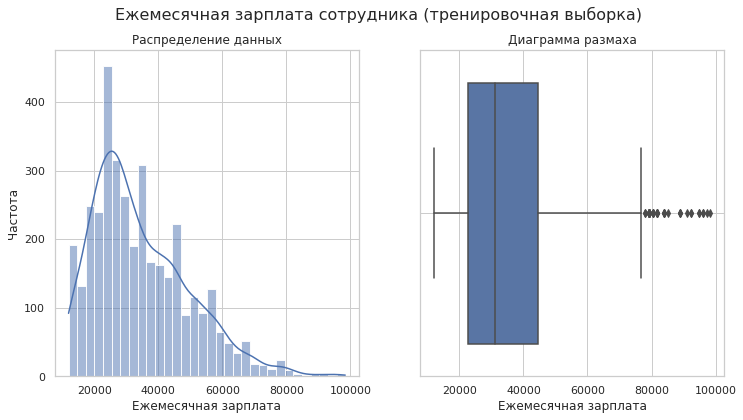


Описательная статистика
count     3755.000000
mean     34457.416778
std      15050.643870
min      12000.000000
25%      22800.000000
50%      31200.000000
75%      44400.000000
max      98400.000000
Name: salary, dtype: float64


In [ ]:
num_features_stats(train['salary'], 'Ежемесячная зарплата', 'Ежемесячная зарплата сотрудника (тренировочная выборка)')

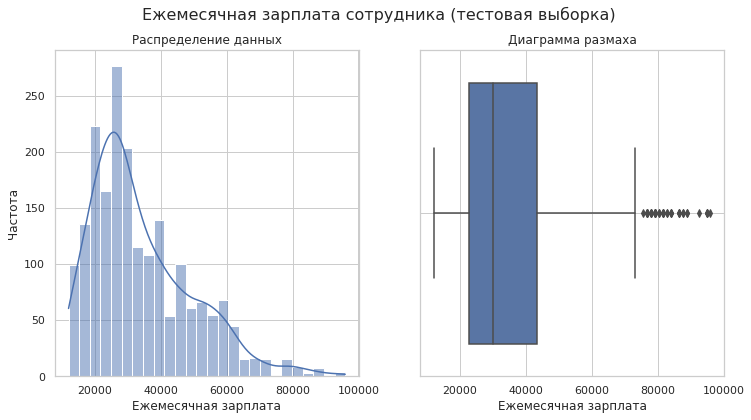


Описательная статистика
count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


In [ ]:
num_features_stats(X_test['salary'], 'Ежемесячная зарплата', 'Ежемесячная зарплата сотрудника (тестовая выборка)')

Входные признаки распределены аналогично данным первой задачи, в схожих соотношениях, с теми же значениями. Рассмотрим распределение целевого признака:

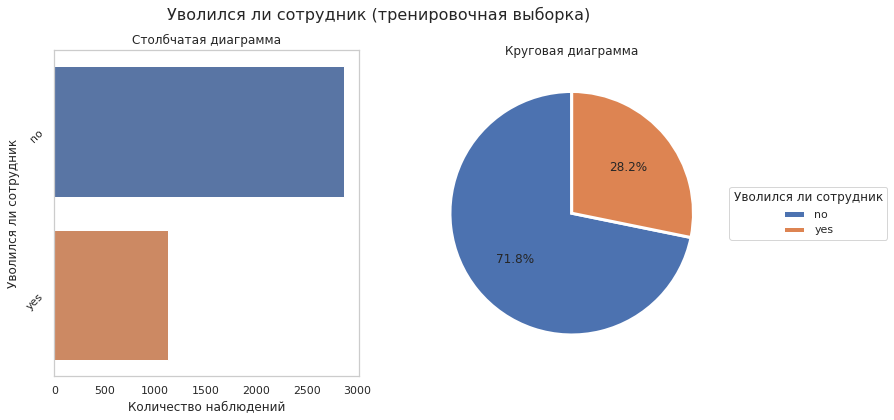

In [ ]:
cat_features_stats(train_clf['quit'], 'Уволился ли сотрудник', 'Уволился ли сотрудник (тренировочная выборка)')

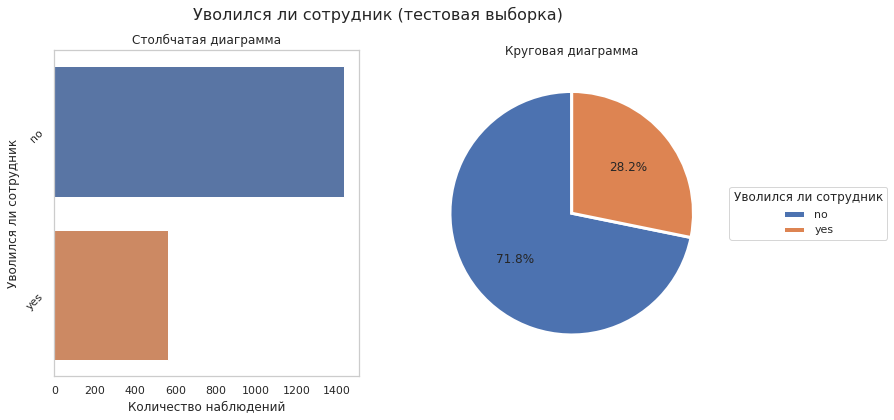

In [ ]:
cat_features_stats(y_test_clf['quit'], 'Уволился ли сотрудник', 'Уволился ли сотрудник (тестовая выборка)')

Наблюдается дисбаланс классов, 71,8% сотрудников продолжают работать, 28,2% уволились, однако соотношение классов в тестовой выборке такое же, как и в тренировочной.

### Портрет уволившегося сотрудника

Разделим выборку на две:  
- те, кто уволился,  
- те, кто продолжил работать

In [ ]:
train_quit = train_clf.query('quit == "yes"')
train_quit_no = train_clf.query('quit == "no"')

Расмотрим отдельно уволившихся:

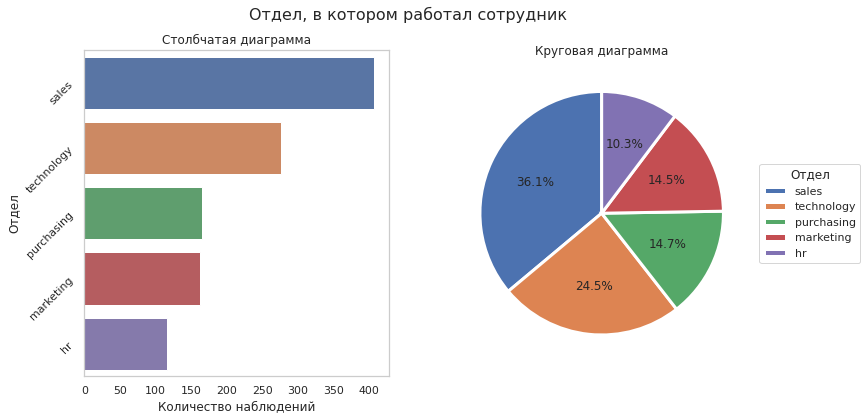

In [ ]:
cat_features_stats(train_quit['dept'], 'Отдел', 'Отдел, в котором работал сотрудник')

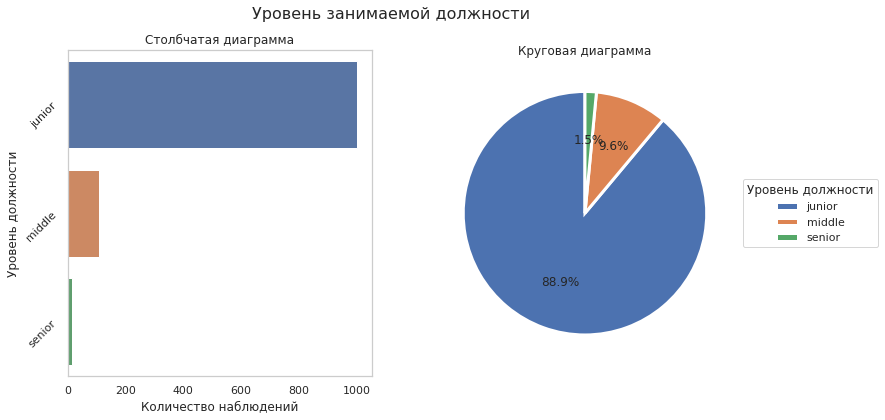

In [ ]:
cat_features_stats(train_quit['level'], 'Уровень должности', 'Уровень занимаемой должности')

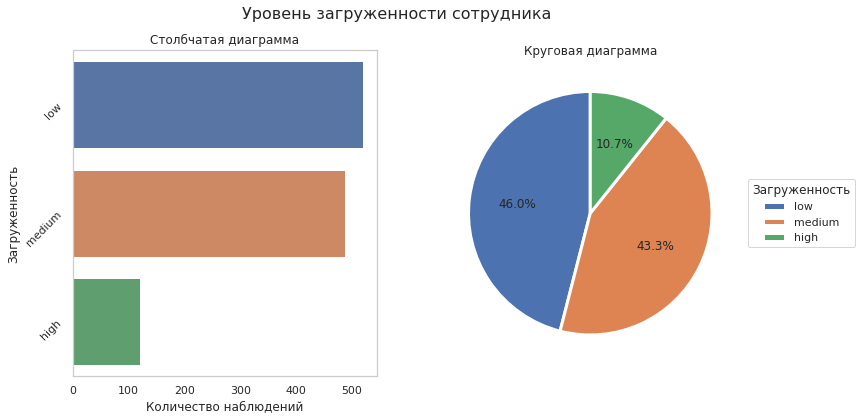

In [ ]:
cat_features_stats(train_quit['workload'], 'Загруженность', 'Уровень загруженности сотрудника')

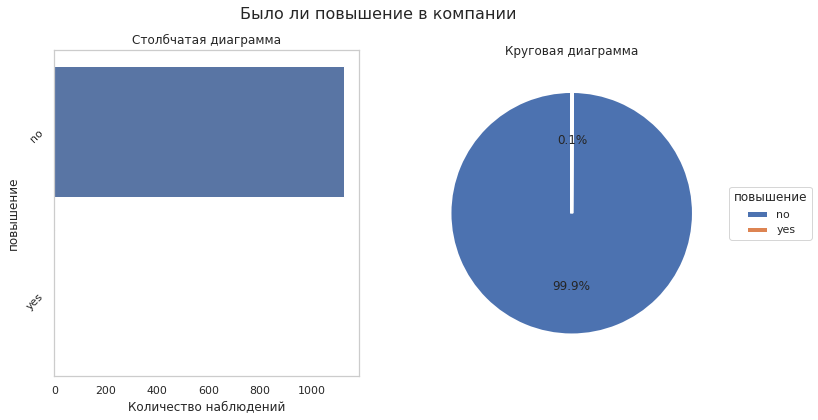

In [ ]:
cat_features_stats(train_quit['last_year_promo'], 'повышение', 'Было ли повышение в компании')

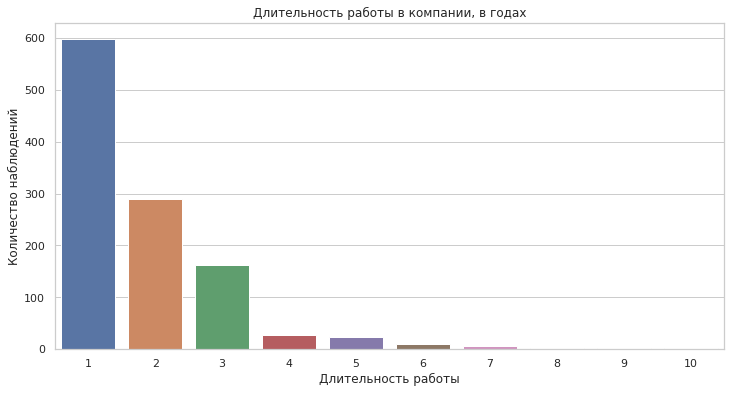

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x=train_quit['employment_years'])
plt.title('Длительность работы в компании, в годах')
plt.ylabel('Количество наблюдений')
plt.xlabel('Длительность работы')
plt.show();

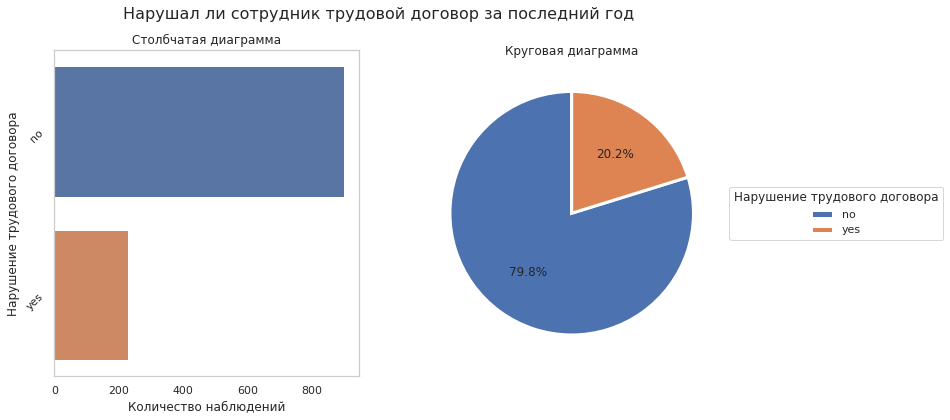

In [ ]:
cat_features_stats(train_quit['last_year_violations'], 'Нарушение трудового договора', 'Нарушал ли сотрудник трудовой договор за последний год')

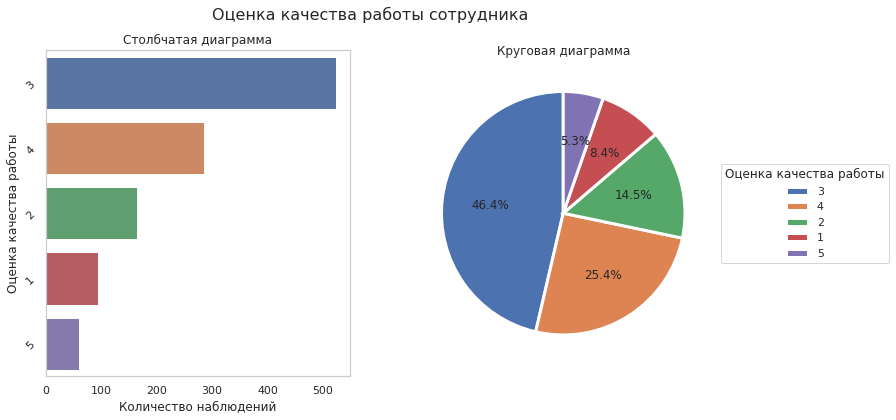

In [ ]:
cat_features_stats(train_quit['supervisor_evaluation'], 'Оценка качества работы', 'Оценка качества работы сотрудника')

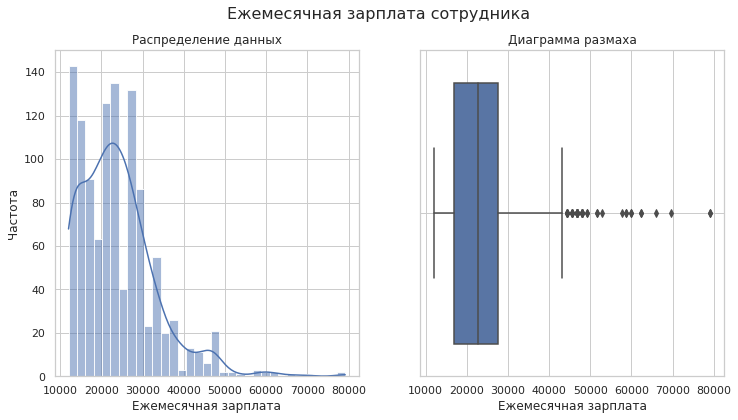


Описательная статистика
count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64


In [ ]:
num_features_stats(train_quit['salary'], 'Ежемесячная зарплата', 'Ежемесячная зарплата сотрудника')

Портрет уволившегося сотрудника:  
- вероятнее работает в `отделе продаж` или `технологическом отделе`,  
- занимает позицию `junior`,  
- в 99,9% случаев не получал повышения за последний год,  
- Как правило работает в компании не более 2 лет,  
- В 80% случаев не нарушал трудовой договор,  
- в 75% наблюдений заработная плата не превышает 27 600 р.

### Сравнительный анализ зарплат

Сравним зарплаты уволившихся и продолживших работать сотрудников

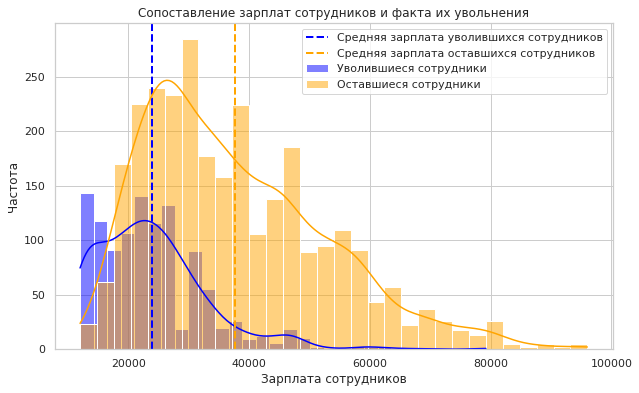

In [ ]:
plt.figure(figsize=(10, 6))

sns.histplot(train_quit['salary'],
             bins=30,
             color='blue',
             alpha=0.5,
             label='Уволившиеся сотрудники',
             kde=True)
plt.axvline(train_quit['salary'].mean(),
            color='blue',
            linestyle='--',
            linewidth=2,
            label='Средняя зарплата уволившихся сотрудников')

sns.histplot(train_quit_no['salary'],
             bins=30,
             color='orange',
             alpha=0.5,
             label='Оставшиеся сотрудники',
             kde=True)
plt.axvline(train_quit_no['salary'].mean(),
            color='orange',
            linestyle='--',
            linewidth=2,
            label='Средняя зарплата оставшихся сотрудников')

plt.title('Сопоставление зарплат сотрудников и факта их увольнения')
plt.xlabel('Зарплата сотрудников')
plt.ylabel('Частота')
plt.legend()
plt.show()

Заработная плата сотрудников, покинувших компанию, примерно вдвое ниже тех, кто продолжил работать. Это может быть обусловленно малым опытом работы, позицией junior, отсутствием повышений за последний год.

### Уровень удовлетворённости работой

In [ ]:
quit_rate = y_test_clf.merge(y_test, left_index=True, right_index=True)
quit_yes_rate = quit_rate.query('quit == "yes"')
quit_no_rate = quit_rate.query('quit == "no"')

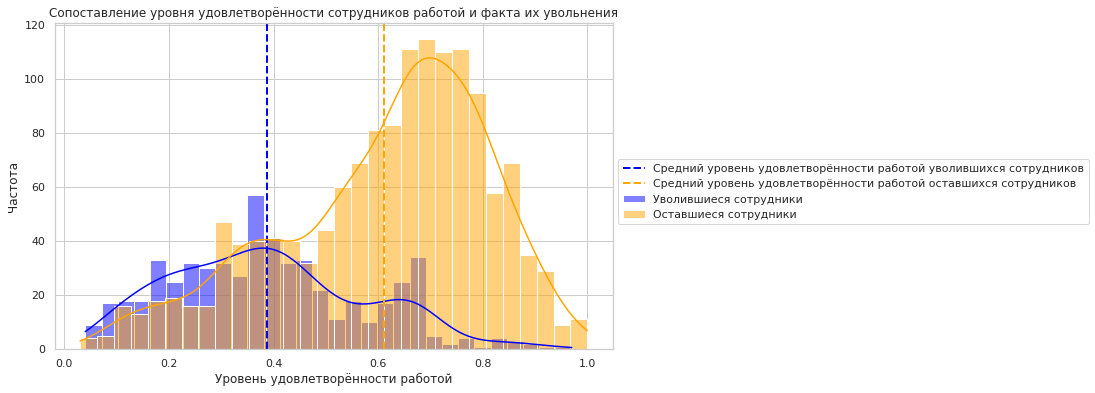

In [ ]:
plt.figure(figsize=(10, 6))

sns.histplot(quit_yes_rate['job_satisfaction_rate'],
             bins=30,
             color='blue',
             alpha=0.5,
             label='Уволившиеся сотрудники',
             kde=True)
plt.axvline(quit_yes_rate['job_satisfaction_rate'].mean(),
            color='blue',
            linestyle='--',
            linewidth=2,
            label='Средний уровень удовлетворённости работой уволившихся сотрудников')

sns.histplot(quit_no_rate['job_satisfaction_rate'],
             bins=30,
             color='orange',
             alpha=0.5,
             label='Оставшиеся сотрудники',
             kde=True)
plt.axvline(quit_no_rate['job_satisfaction_rate'].mean(),
            color='orange',
            linestyle='--',
            linewidth=2,
            label='Средний уровень удовлетворённости работой оставшихся сотрудников')

plt.title('Сопоставление уровня удовлетворённости сотрудников работой и факта их увольнения')
plt.xlabel('Уровень удовлетворённости работой')
plt.ylabel('Частота')
plt.legend(loc='upper left',bbox_to_anchor=(1, 0.6))
plt.show()

Уволившиеся сотрудники склонны ниже оченивать удовлетворённость работой, это логично, они оценивают её в среднем ниже 0,4, в то время как оставшиеся работники в среднем ставят оценку чуть выше 0,6. Имеет смысл обратить внимание на предоставляемые условия, поскольку 0,6 - тоже невысокое значение, есть риски оттока сотрудников.

### Промежуточный вывод

Среди сотрудников, покинувших компанию, высока доля людей, занимающих позицию `junior`, не получающих повышения за последний год, в большинстве случаев получающих не более 27 тыс. р., и работающих в организации как правило не более 2 лет.

## Добавление нового признака

Добавим оценки удовлетворённости сотрудников работой, предсказанные лучшей моделью из первой задачи

In [ ]:
train_clf['rate_predict'] = randomized_search.predict(train_clf)
X_test_clf['rate_predict'] = randomized_search.predict(X_test_clf)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
test_clf = X_test_clf.merge(y_test_clf, left_index=True, right_index=True)
X_train_clf = train_clf.drop(columns='quit')
y_train_clf = train_clf['quit']

X_test_clf = test_clf.drop(columns='quit')
y_test_clf = test_clf['quit']

## Подготовка данных

Так как входные признаки анлогичны предыдущей задаче, не будем менять пайплайн для подготовки данных, только добавим новый признак в количественным признакам (предсказанная степень удовлетворённости работой):

In [ ]:
num_col = ['salary', 'employment_years', 'supervisor_evaluation', 'rate_predict']

Кодируем целевой признак с помощью LabelEncoder()

In [ ]:
label_encoder = LabelEncoder()
y_train_clf = label_encoder.fit_transform(y_train_clf)
y_test_clf = label_encoder.transform(y_test_clf)

In [ ]:
final_clf = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression())
    ]
)

## Обучение модели

### Задание списка моделей и гиперпараметров

In [ ]:
param_distributions_clf = [
    {
        'models':[LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1,11),
        'models__penalty': ['l1', 'l2', 'elasticnet', None],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1,30),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_split': range(2, 21),
        'models__min_samples_leaf': range(1, 16),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1,11),
        'models__class_weight': [None, 'balanced'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']
    }
]

### Подбор оптимальной модели и гиперпараметров

In [ ]:
randomized_search_clf = RandomizedSearchCV(
    final_clf,
    param_distributions_clf,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [ ]:
randomized_search_clf.fit(X_train_clf, y_train_clf)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('simple_imputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simple_impute...
                                         'models__min_samples_split': range(2, 21),
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': range(1, 11),
                                         'models__class_weight': [None,
                                                                  'balanced'],
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [ ]:
print('Метрика ROC-AUC на обучающей выборке:', randomized_search_clf.best_score_)

Метрика ROC-AUC на обучающей выборке: 0.9244717712297994


In [ ]:
print('Метрика ROC-AUC на тестовой выборке:',
      roc_auc_score(y_test_clf, randomized_search_clf.predict_proba(X_test_clf)[:,1]))

Метрика ROC-AUC на тестовой выборке: 0.9150152363736936


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Промежуточный вывод

Оптимальной оказалась модель дерева принятия решений с гиперпараметрами max_depth=6, min_samples_leaf=12, min_samples_split=17, random_state=42, метрика ROC-AUC показала высокое качество как на тренировочной (0,9245), так и на тестовой выборке (0,915), что говорит о высокой точности модели.

# Итоговый вывод

Перед нами стояла ***цель - предсказать отток сотрудников***. Для достижения этой цели были сформулированы следущие задачи:  
- построить модель, которая сможет **предсказать уровень удовлетворённости сотрудника работой на основе данных заказчика**,  
- построить модель, которая сможет **предсказать: уволится ли сотрудник из компании**.  

В рамках выполнения выдвинутых задач были выполнены следующие **шаги**:

- предобработаны данные (удалены явные и неявные дубликаты, выявлены пропущенные значения, исправлены некорректные написания значений признаков),  
- осуществлён исследовательский анализ данных и сделаны выводы на его основе,  
- разработан пайплайн для подготовки данных к обучению, перебора моделей и гиперпараметров для них,  
- подобраны оптимальные модели как для прогнозирования уровня удовлетворённости сотрудника работой, так и для предсказания факта увольнения,  
- обучены и протестированы полученные модели,  
- предсказаны необходимые признаки на основе оптимальных моделей.  

Лучшее качество показали следующие модели:  
- для прогнозирования уровня удовлетворённости сотрудника работой (непрерывный признак от 0 до 1): Дерево принятия решений с гиперпараметрами max_features=8, min_samples_leaf=6, min_samples_split=13, random_state=42, масштабирование осуществлялось скелером RobustScaler();
- для прогнозирования увольнения сотрудников (бинарный признак: yes, no): модель дерева принятия решений с гиперпараметрами max_depth=6, min_samples_leaf=12, min_samples_split=17, random_state=42, метрика качества ROC-AUC на обучающей и тестовой выборках больше 0,91.  

Рекомендации:
- Так как для сотрудников важную роль играет оценка руководителем качества их работы, целесообразно обратить внимание на форму обратной связи от руководителей, а также выявить причины низких оценок (15% оценок - `1` и `2`).  
- У 99,9% уволившихся сотрудников не было повышения за последний год. Возможно, необходимо усовершенствовать систему адаптации для более быстрого карьерного роста сотрудников.  
- Заработная плата 75% уволившихся сотрудников не превышала 27 тыс., причина вероятно в низкой позиции и отсутствии повышений. 80% уволившихся занимали должности уровня `junior`,  следует больше внимания уделить их развитию, а также выстроить систему мотивации для таких сотрудников.  
- Целесообразно провести дополнительные ислледования для сотрудников `отдела продаж` и `технологического отдела`, поскольку в них наиболее высокая доля уволившихся сотрудников.